In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from keras import backend as K

In [2]:
#load data then preprocessing
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv',sep=',',header=0)
#fill empty cells with empty strings (vader gives these a neutral rating)
data = data.fillna('')
#features dataframe
features = pd.DataFrame()
print(data['Title'].iat[3] + data['Review Text'].iat[3])

My favorite buy!I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!


In [3]:
title_sentiment = []
text_sentiment = []
#add sentiment values to feature dataframe
#sentiment values are pulled from nltk's VADER sentiment analysis
for i in range(len(data)):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(data['Title'].iat[i])
    title_sentiment.append(ss['compound'])
    ss = sid.polarity_scores(data['Review Text'].iat[i])
    text_sentiment.append(ss['compound'])
features['Title Sentiment'] = title_sentiment
features['Text Sentiment'] = text_sentiment
#add recommended and feedback to feature dataframe
features['Recommended'] = data['Recommended IND'].values
features['Feedback'] = data['Positive Feedback Count'].values

In [4]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
ros_features, ros_Y = ros.fit_resample(features, data['Rating'])
rus_features, rus_Y = rus.fit_resample(features, data['Rating'])
#make dummies dataframe of Y
Y = pd.get_dummies(data['Rating'])
rus_Y = pd.get_dummies(rus_Y)
ros_Y = pd.get_dummies(ros_Y)
print(features.head(10))


   Title Sentiment  Text Sentiment  Recommended  Feedback
0           0.0000          0.8932            1         0
1           0.0000          0.9729            1         4
2           0.0000          0.9427            0         0
3           0.5093          0.5727            1         0
4           0.3182          0.9291            1         6
5           0.0000          0.9419            0         4
6           0.5106          0.8004            1         1
7           0.2960         -0.0909            1         4
8           0.3182          0.7175            1         0
9           0.5562         -0.3724            1         0


In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [160]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, Y, test_size=0.3)
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=3, mode='max')
#convert to tensor while splitting data into batches
Xtrain = tf.convert_to_tensor(Xtrain)
Ytrain = tf.convert_to_tensor(Ytrain)
Xtest = tf.convert_to_tensor(Xtest)
Ytest = tf.convert_to_tensor(Ytest)
#construct and compile model
model = models.Sequential()
#tested other activation functions, relu results in the highest accuracy
model.add(layers.Dense(2048, activation='sigmoid', input_shape=(4,)))
model.add(layers.Dense(512, activation='sigmoid'))
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dense(128, activation='sigmoid'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(5))
model.summary()
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy', 'mean_squared_error', recall_m, precision_m, f1_m])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 2048)              10240     
                                                                 
 dense_91 (Dense)            (None, 512)               1049088   
                                                                 
 dense_92 (Dense)            (None, 256)               131328    
                                                                 
 dense_93 (Dense)            (None, 128)               32896     
                                                                 
 dense_94 (Dense)            (None, 5)                 645       
                                                                 
Total params: 1,224,197
Trainable params: 1,224,197
Non-trainable params: 0
_________________________________________________________________


In [161]:
history = model.fit(Xtrain, 
                    Ytrain, 
                    epochs=20, 
                    verbose=1, 
                    validation_data=(Xtest, Ytest),
                    callbacks=[callback])

Epoch 1/20
514/514 [==============================] - 6s 11ms/step - loss: 1.1486 - accuracy: 0.5769 - mean_squared_error: 1.1515 - recall_m: 0.7153 - precision_m: 0.4677 - f1_m: 0.5511 - val_loss: 0.9182 - val_accuracy: 0.6213 - val_mean_squared_error: 3.6066 - val_recall_m: 0.8975 - val_precision_m: 0.4506 - val_f1_m: 0.6000
Epoch 2/20
514/514 [==============================] - 5s 11ms/step - loss: 0.8818 - accuracy: 0.6280 - mean_squared_error: 4.3317 - recall_m: 0.9289 - precision_m: 0.4280 - f1_m: 0.5849 - val_loss: 0.8825 - val_accuracy: 0.6215 - val_mean_squared_error: 4.8323 - val_recall_m: 0.9215 - val_precision_m: 0.4400 - val_f1_m: 0.5955
Epoch 3/20
514/514 [==============================] - 5s 11ms/step - loss: 0.8677 - accuracy: 0.6315 - mean_squared_error: 5.0705 - recall_m: 0.9279 - precision_m: 0.4315 - f1_m: 0.5885 - val_loss: 0.8817 - val_accuracy: 0.6148 - val_mean_squared_error: 6.1216 - val_recall_m: 0.9362 - val_precision_m: 0.4310 - val_f1_m: 0.5901
Epoch 4/20
51

In [162]:
test_mse, test_loss, test_acc, test_recall, test_precision, test_f1 = model.evaluate(Xtest, Ytest, verbose=2)


221/221 - 1s - loss: 0.8795 - accuracy: 0.6240 - mean_squared_error: 5.9033 - recall_m: 0.9314 - precision_m: 0.4310 - f1_m: 0.5892 - 677ms/epoch - 3ms/step


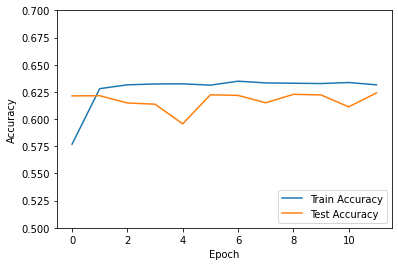

In [170]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.7])
plt.legend(loc='lower right')

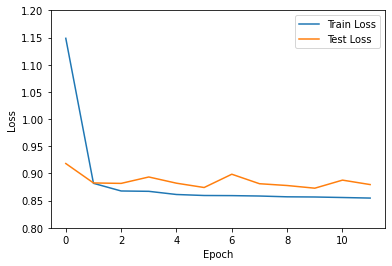

In [169]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.8, 1.2])
plt.legend(loc='upper right')

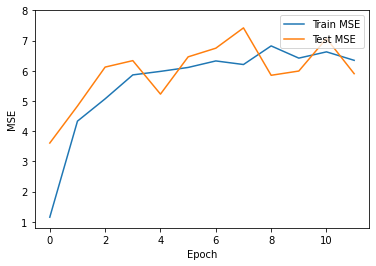

In [168]:
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label = 'Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0.8, 8])
plt.legend(loc='upper right')

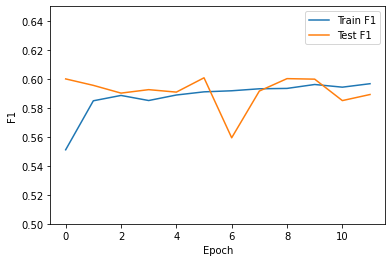

In [166]:
plt.plot(history.history['f1_m'], label='Train F1')
plt.plot(history.history['val_f1_m'], label = 'Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.ylim([0.5, 0.65])
plt.legend(loc='upper right')

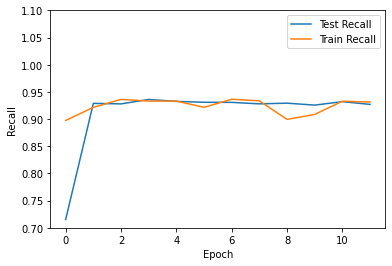

In [167]:
plt.plot(history.history['recall_m'], label='Test Recall')
plt.plot(history.history['val_recall_m'], label = 'Train Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.7, 1.1])
plt.legend(loc='upper right')

In [173]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, Y, test_size=0.3)
knn = KNeighborsClassifier(n_neighbors=50,algorithm='ball_tree')
knn.fit(Xtrain, Ytrain)
rforest = RandomForestClassifier(n_estimators=500,criterion='entropy',random_state=0)
rforest.fit(Xtrain, Ytrain)
gini = tree.DecisionTreeClassifier(criterion='gini',random_state=0)
gini.fit(Xtrain, Ytrain)
info = tree.DecisionTreeClassifier(criterion='entropy',random_state=0)
info.fit(Xtrain, Ytrain)
nn = MLPClassifier(max_iter=1000, activation='relu', random_state=0)
nn.fit(Xtrain, Ytrain)

MLPClassifier(max_iter=1000, random_state=0)

In [174]:
knnpred = knn.predict(Xtest)
rfpred = rforest.predict(Xtest)
ginipred = gini.predict(Xtest)
infopred = info.predict(Xtest)
nnpred = nn.predict(Xtest)

[Text(0, 1, '0.526256'),
 Text(0, 1, '0.541726'),
 Text(0, 1, '0.532359'),
 Text(0, 1, '0.531365'),
 Text(0, 1, '0.541016'),
 Text(0, 1, '0.624042')]

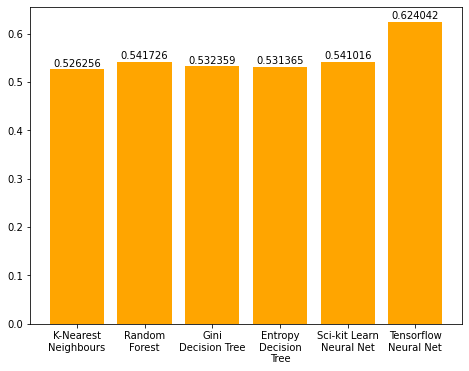

In [176]:
accuracies = [accuracy_score(Ytest, knnpred), accuracy_score(Ytest, rfpred), accuracy_score(Ytest, ginipred), accuracy_score(Ytest, infopred), accuracy_score(Ytest, nnpred), history.history['val_accuracy'][-1]]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1.1])

rect = ax.bar(['K-Nearest\nNeighbours','Random\nForest','Gini\nDecision Tree','Entropy\nDecision\nTree','Sci-kit Learn\nNeural Net','Tensorflow\nNeural Net'], accuracies, color='orange')
ax.bar_label(rect, padding=1)


In [ ]:
names = ['No\nSampling', 'Under\nSampling','Over\nSampling']
acc = [0.6435,0.4450,0.5034]
los = [0.8360,1.1106,1.0358]
mse = [8.7161,4.5401,11.3707]
x = np.arange(len(names))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1.5])
rects1 = ax.bar(x - 0.25, acc, 0.25, label='Accuracy')
rects2 = ax.bar(x + 0.25, los, 0.25, label='Loss')
ax.set_ylabel('Accuracy & Loss')
ax2 = ax.twinx()
ax2.set_ylabel('Mean Squared Error')
rects3 = ax2.bar(x, mse, 0.25, color='green', label='MSE')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax2.bar_label(rects3, padding=3)
ax.set_xticks(x, names)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

In [ ]:
names= ['1','2','3','4','5'][::-1]
freq = data['Rating'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1.1])
ax.bar(names, freq)

In [ ]:
exploded = data['Review Text'].explode()
freq = [word_tokenize(i) for i in exploded]
freq = pd.Series(freq).explode()
freq=np.concatenate(freq.values, axis=None)

In [ ]:
fdist = nltk.FreqDist(freq)
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("n't")
dict_filter = lambda word_freq, stopwords: dict( (word,word_freq[word]) for word in word_freq if word not in stopwords and len(word) > 2)
filtered_fdist = dict_filter(fdist, stopwords)

In [ ]:
a = list(filtered_fdist.keys())
b = list(filtered_fdist.values())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1.1])
ax.bar(a[:10], b[:10])